In [89]:
import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import KNNImputer
from sklearn.utils.validation import check_is_fitted

In [90]:
# my data
data = pd.read_csv('../data/all-4 (1).csv')
cols = ["memory_alloc","cpu_alloc","cpu_usage","memory","number_instances"]
data[cols] = data[cols].replace({ 0:np.nan})
data = data.dropna(subset=['number_instances', 'memory_alloc','cpu_alloc'])
data = data.drop(columns=['Unnamed: 0'])

#### Here we are doing a minor modification at the data in order not to have values like 1000000000.0 (and not to observe very big deviation)

In [91]:
data['cpu_alloc'] = data['cpu_alloc'].replace(100000000.0, 1)
data['cpu_alloc'] = data['cpu_alloc'].replace(200000000.0, 2)
data['cpu_alloc'] = data['cpu_alloc'].replace(300000000.0, 3)
data['cpu_alloc'] = data['cpu_alloc'].replace(400000000.0, 4)

In [92]:
data['memory_alloc'] = data['memory_alloc'].replace(248000000.0, 248)

In [93]:
data

,served_request,request_rate,number_instances,response_time,performance,cpu_usage,cpu_alloc,memory,memory_alloc
13,0.000000,0.000000,1.0,6960.363826,0.000000,39.366667,2.0,9.718443e+06,32.0
14,0.000000,8.333333,1.0,6960.363826,33.334054,39.366667,2.0,9.718443e+06,32.0
15,0.000000,8.333333,1.0,6960.363826,33.334054,39.366667,2.0,9.718443e+06,32.0
16,20.333333,8.333333,1.0,6960.363826,33.334054,39.366667,2.0,9.718443e+06,32.0
17,20.333333,8.333333,1.0,6960.363826,33.334054,39.366667,2.0,9.718443e+06,32.0
...,...,...,...,...,...,...,...,...,...
35263,39.428571,16.571429,3.0,6.409822,10.665537,37.100000,3.0,3.025130e+07,248.0
35264,39.428571,16.571429,3.0,6.409822,10.665537,37.100000,3.0,3.025130e+07,248.0
35265,39.428571,16.571429,3.0,13.592183,10.665537,37.100000,3.0,3.025130e+07,248.0
35266,39.428571,16.571429,3.0,13.592183,10.665537,37.100000,3.0,3.025130e+07,248.0


In [94]:
data = data.round(decimals=2)

In [95]:
data.shape

(30507, 9)

In [96]:
# Data Description
data.describe()

,served_request,request_rate,number_instances,response_time,performance,cpu_usage,cpu_alloc,memory,memory_alloc
count,30507.000000,30507.000000,30507.000000,30507.000000,30507.000000,29608.000000,30507.000000,2.960900e+04,30507.000000
mean,22.391686,12.816734,1.366047,507.126632,61.012693,38.267292,2.518865,3.148796e+07,98.991051
std,63.763678,37.790858,0.790343,2753.333043,41.012961,9.283692,1.483380,6.424793e+06,84.894916
min,0.000000,0.000000,1.000000,0.000000,0.000000,14.870000,1.000000,2.083499e+06,32.000000
25%,0.000000,0.000000,1.000000,0.000000,7.970000,30.700000,2.000000,2.705818e+07,56.000000
50%,1.000000,0.330000,1.000000,1.520000,66.740000,39.235000,2.000000,3.301786e+07,56.000000
75%,22.110000,10.140000,1.000000,7.310000,100.000000,45.430000,2.000000,3.570483e+07,56.000000
max,636.000000,322.000000,5.000000,55029.400000,218.220000,73.400000,7.000000,5.108668e+07,248.000000


#### Remove rows with response time = 0

In [97]:
data_2 = data.drop(data[data['response_time'] == 0.000000 ].index) 

In [98]:
data_2 = data_2.round(decimals=2)

#### Reset index in dataframe 

In [99]:
data_3 = data_2.reset_index()
data_3 = data_3.drop(columns=['index'])
data_3.head()

,served_request,request_rate,number_instances,response_time,performance,cpu_usage,cpu_alloc,memory,memory_alloc
0,0.00,0.00,1.0,6960.36,0.00,39.37,2.0,9718442.67,32.0
1,0.00,8.33,1.0,6960.36,33.33,39.37,2.0,9718442.67,32.0
2,0.00,8.33,1.0,6960.36,33.33,39.37,2.0,9718442.67,32.0
3,20.33,8.33,1.0,6960.36,33.33,39.37,2.0,9718442.67,32.0
4,20.33,8.33,1.0,6960.36,33.33,39.37,2.0,9718442.67,32.0


# Data Imputation technique 1

# Missing Values Imputation 
#### We are using an inheritance from the sklearn.base classes (BaseEstimator, TransformerMixin). 

# Group Data according to configuration and then for each configuration take the mean or the meadian

In [100]:
#Missing Values Imputation 

class GroupImputer(BaseEstimator, TransformerMixin):
    '''
    Class used for imputing missing values in a pd.DataFrame using either mean or median of a group.

    Parameters
    ----------
    group_cols : list
        List of columns used for calculating the aggregated value
    target : str
        The name of the column to impute
    metric : str
        The metric to be used for remplacement, can be one of ['mean', 'median']
    Returns
    -------
    X : array-like
        The array with imputed values in the target column
    '''

    def __init__(self, group_cols, target, metric='mean'):
        assert metric in ['mean', 'median'], 'Unrecognized value for metric, should be mean/median'
        #assert type(group_cols) == list, 'group_cols should be a list of columns'
        assert type(target) == str, 'target should be a string'

        self.group_cols = group_cols
        self.target = target
        self.metric = metric

    def fit(self, X, y=None):
        assert pd.isnull(X[self.group_cols]).any(axis=None) == False, 'There are missing values in group_cols'

        impute_map = X.groupby(self.group_cols)[self.target].agg(self.metric).reset_index(drop=False)#
        
        print(impute_map)
        self.impute_map_ = impute_map

        return self

    def transform(self, X, y=None):
        # make sure that the imputer was fitted
        check_is_fitted(self, 'impute_map_')

        X = X.copy()

        for index, row in self.impute_map_.iterrows():
            ind = (X[self.group_cols] == row[self.group_cols]).all(axis=1)
            X.loc[ind] = X.loc[ind].fillna(row[self.target])

        return X.values


conf_columns = ['number_instances', 'cpu_alloc', 'memory_alloc' ]

for col_name in data.columns:
    if col_name != 'number_instances' and col_name != 'cpu_alloc' and col_name!= 'memory_alloc' :

        imp = GroupImputer(group_cols=conf_columns,
                           target=col_name,
                           metric='median')

        df_imp = pd.DataFrame(imp.fit_transform(data_2),
                              columns=data_2.columns)



for col_name in data_2.columns:
    if col_name != 'number_instances' and col_name != 'cpu_alloc' and col_name!= 'memory_alloc' :

        print(f'data contains {sum(pd.isnull(data_2[col_name]))} missing values.')
        print(f'df_imp contains {sum(pd.isnull(df_imp[col_name]))} missing values.')


    number_instances  cpu_alloc  memory_alloc  served_request
0                1.0        1.0         248.0           22.33
1                1.0        2.0          32.0           10.67
2                1.0        2.0          48.0          636.00
3                1.0        2.0          56.0            1.00
4                1.0        2.0         248.0           44.67
5                1.0        3.0          32.0           14.33
6                1.0        3.0         248.0           72.50
7                1.0        4.0         248.0           90.67
8                1.0        6.0          32.0           58.33
9                2.0        1.0         248.0           25.20
10               2.0        2.0         248.0           46.80
11               2.0        3.0         248.0           78.80
12               2.0        6.0          32.0          141.00
13               2.0        7.0          32.0            0.60
14               3.0        1.0         248.0           24.29
15      

In [101]:
df_imp.isna().sum()

served_request      0
request_rate        0
number_instances    0
response_time       0
performance         0
cpu_usage           0
cpu_alloc           0
memory              0
memory_alloc        0
dtype: int64

In [102]:
df_imp_1 = df_imp.groupby(['number_instances', 'cpu_alloc', 'memory_alloc']).size().reset_index()

lista = []
for row in df_imp_1.iterrows():
    lista.append(df_imp_1[['number_instances', 'cpu_alloc', 'memory_alloc']])


In [103]:
df_imp_1 = df_imp_1.drop(columns=[0])
dictionairy = df_imp_1.to_dict('index')

In [104]:
def label_race(row):
    
    if row['number_instances'] == 1.0 and row['cpu_alloc'] == 1.0 and row['memory_alloc'] == 248.0 :
        return 0
    elif row['number_instances'] == 1.0 and row['cpu_alloc'] == 2.0 and row['memory_alloc'] == 32.0:
        return 1
    elif row['number_instances'] == 1.0 and row['cpu_alloc'] == 2.0 and row['memory_alloc'] == 48.0:
        return 2
    elif row['number_instances'] == 1.0 and row['cpu_alloc'] == 2.0 and row['memory_alloc'] == 56.0:
        return 3
    elif row['number_instances'] == 1.0 and row['cpu_alloc'] == 2.0 and row['memory_alloc'] == 248.0:
        return 4
    elif row['number_instances'] == 1.0 and row['cpu_alloc'] == 3.0 and row['memory_alloc'] == 32.0:
        return 5
    elif row['number_instances'] == 1.0 and row['cpu_alloc'] == 3.0 and row['memory_alloc'] == 248.0:
        return 6
    elif row['number_instances'] == 1.0 and row['cpu_alloc'] == 4.0 and row['memory_alloc'] == 248.0:
        return 7
    elif row['number_instances'] == 1.0 and row['cpu_alloc'] == 6.0 and row['memory_alloc'] == 32.0:
        return 8
    elif row['number_instances'] == 2.0 and row['cpu_alloc'] == 1.0 and row['memory_alloc'] == 248.0:
        return 9
    elif row['number_instances'] == 2.0 and row['cpu_alloc'] == 2.0 and row['memory_alloc'] == 248.0:
        return 10
    elif row['number_instances'] == 2.0 and row['cpu_alloc'] == 3.0 and row['memory_alloc'] == 248.0:
        return 11
    elif row['number_instances'] == 2.0 and row['cpu_alloc'] == 6.0 and row['memory_alloc'] == 32.0:
        return 12
    elif row['number_instances'] == 2.0 and row['cpu_alloc'] == 7.0 and row['memory_alloc'] == 32.0:
        return 13
    elif row['number_instances'] == 3.0 and row['cpu_alloc'] == 1.0 and row['memory_alloc'] == 248.0:
        return 14
    elif row['number_instances'] == 3.0 and row['cpu_alloc'] == 2.0 and row['memory_alloc'] == 248.0:
        return 15
    elif row['number_instances'] == 3.0 and row['cpu_alloc'] == 3.0 and row['memory_alloc'] == 248.0:
        return 16
    elif row['number_instances'] == 4.0 and row['cpu_alloc'] == 1.0 and row['memory_alloc'] == 248.0:
        return 17
    elif row['number_instances'] == 4.0 and row['cpu_alloc'] == 2.0 and row['memory_alloc'] == 248.0:
        return 18
    elif row['number_instances'] == 5.0 and row['cpu_alloc'] == 1.0 and row['memory_alloc'] == 248.0:
        return 19
  
df_imp_2 = df_imp.copy()
df_imp_2['configuration'] = df_imp_2.apply (lambda row: label_race(row), axis=1)



In [105]:
df_imp_2['configuration'].unique()

array([ 1,  2,  3,  0,  9, 14, 17, 19,  4, 10, 15, 18,  5,  8, 12, 13,  6,
        7, 11, 16])

In [106]:
df_imp_2['configuration'].isna().sum()

0

In [107]:
df_imp_2.shape

(19925, 10)

# Algorithms Experimentation

## Decision Tree Regressor 

#### 1) Tι συμβαινει αν απλα πεταξω ολες τις γραμμες που εχουν nan values

##### Σε ολα αυτα τα κελια μπορει αντι του Decision Tree Regressor να μπει οποιος αλγοριθμος θελει καποιος να τεσταρει

In [75]:
## Decision Tree Regressor for the  Model which uses the configuration variables in order to predict the performance (variable)
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn import tree
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

data_4 = data_3.dropna()

X_train, X_test, y_train, y_test = train_test_split(df_imp_2.drop(columns=['performance', 'served_request',
                                                                         'response_time', 'memory' , 'cpu_usage'
                             ]),
                                                    df_imp_2['performance'],random_state=0)
regressor = DecisionTreeRegressor(random_state=0)
regressor.fit(X_train, y_train)
cross_val_score(regressor, X_train, y_train, cv=10)
print(cross_val)
pred = regressor.predict(X_test)
pred_train = regressor.predict(X_train)
# R2_test
print('R2_test: ', r2_score(y_test, pred))
# R2_train
print('R2_train: ', r2_score(y_train, pred_train))
# MSE
print(mean_squared_error(y_test, pred, squared=True))
# RMSE
print(mean_squared_error(y_test, pred, squared=False))
# MAE
print(mean_absolute_error(y_test, pred))


[0.83952746 0.88424507 0.88983686 0.88043853 0.86930334 0.89845793
 0.91525811 0.87277668 0.89103855 0.83410071]
R2_test:  0.9345271582042805
R2_train:  0.9320632844398
127.46091049842408
11.289858745725036
6.478708520435303


## Something wrong with dataset and train/test split
I suspect that most of the test data (maybe all) are not already unseen. In essence you were testing on seen data. For this reason train with test metrics above give the same number.
Following some random sample which validate my concerns.


In [80]:
X_train[X_train['request_rate']==17.00]

,request_rate,number_instances,cpu_alloc,memory_alloc,configuration
18415,17.0,1.0,1.0,248.0,0
10778,17.0,2.0,1.0,248.0,9
18427,17.0,1.0,1.0,248.0,0
10783,17.0,2.0,1.0,248.0,9
18424,17.0,1.0,1.0,248.0,0
10781,17.0,2.0,1.0,248.0,9
10770,17.0,2.0,1.0,248.0,9
10769,17.0,2.0,1.0,248.0,9


In [82]:
y_train[18415]

0.44

In [83]:
X_test[X_test['request_rate']==17.00]

,request_rate,number_instances,cpu_alloc,memory_alloc,configuration
18417,17.0,1.0,1.0,248.0,0
10772,17.0,2.0,1.0,248.0,9
18426,17.0,1.0,1.0,248.0,0


In [84]:
y_test[18417]

0.44

In [85]:
X_train[X_train['request_rate']==49.67]

,request_rate,number_instances,cpu_alloc,memory_alloc,configuration
17956,49.67,1.0,4.0,248.0,7
17943,49.67,1.0,4.0,248.0,7
17953,49.67,1.0,4.0,248.0,7
17957,49.67,1.0,4.0,248.0,7


In [87]:
y_train[17956]

35.56

In [38]:
X_test[X_test['request_rate']==49.67]

,request_rate,number_instances,cpu_alloc,memory_alloc,configuration
17944,49.67,1.0,4.0,248.0,7
18872,49.67,1.0,4.0,248.0,7
17943,49.67,1.0,4.0,248.0,7
17946,49.67,1.0,4.0,248.0,7
18866,49.67,1.0,4.0,248.0,7
17954,49.67,1.0,4.0,248.0,7


In [40]:
y_test[17944]

35.56

## Drop duplicates on dataset

In [78]:
df_imp_2 = df_imp_2.drop_duplicates()

In [79]:
## Decision Tree Regressor for the  Model which uses the configuration variables in order to predict the performance (variable)
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn import tree
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

data_4 = data_3.dropna()

X_train, X_test, y_train, y_test = train_test_split(df_imp_2.drop(columns=['performance', 'served_request',
                                                                         'response_time', 'memory' , 'cpu_usage'
                             ]),
                                                    df_imp_2['performance'],random_state=0)
regressor = DecisionTreeRegressor(random_state=0)
regressor.fit(X_train, y_train)
cross_val = cross_val_score(regressor, X_train, y_train, cv=10)
print(cross_val)
pred = regressor.predict(X_test)
pred_train = regressor.predict(X_train)
# R2_test
print('R2_test: ', r2_score(y_test, pred))
# R2_train
print('R2_train: ', r2_score(y_train, pred_train))
# MSE
print(mean_squared_error(y_test, pred, squared=True))
# RMSE
print(mean_squared_error(y_test, pred, squared=False))
# MAE
print(mean_absolute_error(y_test, pred))


[0.83952746 0.88424507 0.88983686 0.88043853 0.86930334 0.89845793
 0.91525811 0.87277668 0.89103855 0.83410071]
R2_test:  0.8824155102966318
R2_train:  0.8985780285844468
234.96353102787646
15.328520183888477
8.405763357270105


## Drop without 'performance', 'served_request', 'response_time', 'memory' , 'cpu_usage'


In [108]:
df_imp_3 = df_imp_2.drop(columns=['served_request', 'response_time', 'memory' , 'cpu_usage'])
df_imp_3

,request_rate,number_instances,performance,cpu_alloc,memory_alloc,configuration
0,0.00,1.0,0.00,2.0,32.0,1
1,8.33,1.0,33.33,2.0,32.0,1
2,8.33,1.0,33.33,2.0,32.0,1
3,8.33,1.0,33.33,2.0,32.0,1
4,8.33,1.0,33.33,2.0,32.0,1
...,...,...,...,...,...,...
19920,16.57,3.0,10.67,3.0,248.0,16
19921,16.57,3.0,10.67,3.0,248.0,16
19922,16.57,3.0,10.67,3.0,248.0,16
19923,16.57,3.0,10.67,3.0,248.0,16


In [109]:
df_imp_3 = df_imp_3.drop_duplicates()
df_imp_3

,request_rate,number_instances,performance,cpu_alloc,memory_alloc,configuration
0,0.00,1.0,0.00,2.0,32.0,1
1,8.33,1.0,33.33,2.0,32.0,1
19,8.67,1.0,33.33,2.0,32.0,1
20,8.67,1.0,0.00,2.0,32.0,1
39,17.67,1.0,0.00,2.0,32.0,1
...,...,...,...,...,...,...
19882,62.43,3.0,16.59,3.0,248.0,16
19894,62.43,3.0,18.46,3.0,248.0,16
19896,27.43,3.0,18.46,3.0,248.0,16
19910,27.43,3.0,10.67,3.0,248.0,16


In [111]:
## Decision Tree Regressor for the  Model which uses the configuration variables in order to predict the performance (variable)
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn import tree
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

data_4 = data_3.dropna()

X_train, X_test, y_train, y_test = train_test_split(df_imp_3.drop(columns=['performance']),
                                                    df_imp_3['performance'],random_state=0)
regressor = DecisionTreeRegressor(random_state=0)
regressor.fit(X_train, y_train)
cross_val = cross_val_score(regressor, X_train, y_train, cv=10)
print(cross_val)
pred = regressor.predict(X_test)
pred_train = regressor.predict(X_train)
# R2_test
print('R2_test: ', r2_score(y_test, pred))
# R2_train
print('R2_train: ', r2_score(y_train, pred_train))
# MSE
print(mean_squared_error(y_test, pred, squared=True))
# RMSE
print(mean_squared_error(y_test, pred, squared=False))
# MAE
print(mean_absolute_error(y_test, pred))


[0.45655246 0.70537614 0.87557127 0.87112809 0.49078862 0.71633137
 0.58158743 0.82700403 0.90267184 0.74093349]
R2_test:  0.6925003494716668
R2_train:  0.9385552884117815
538.064229177798
23.19621152640659
10.901719342476804


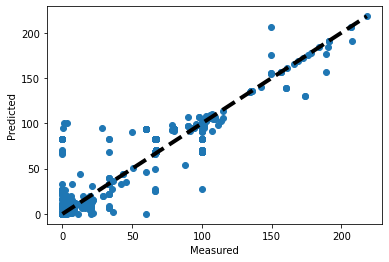

In [52]:
fig, ax = plt.subplots()
ax.scatter(y_test, pred)
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

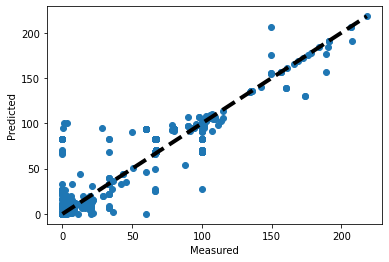

In [53]:
from sklearn.model_selection import cross_val_predict
predicted = cross_val_predict(regressor, X_train, y_train, cv=10)
fig, ax = plt.subplots()
ax.scatter(y_test, pred)
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

## Use a stacking regressor. I have chosen 3 different algorithms but it can be any algorithm (that it can be used for regression). Unfortunatelly this technique does not improve the results. 

In [114]:
from sklearn.experimental import enable_hist_gradient_boosting  # noqa
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LassoCV
from sklearn.linear_model import RidgeCV
from sklearn.pipeline import make_pipeline

"""lasso_pipeline = make_pipeline(processor_lin,
                               LassoCV())

rf_pipeline = make_pipeline(processor_nlin,
                            RandomForestRegressor(random_state=42))

gradient_pipeline = make_pipeline(
    processor_nlin,
    HistGradientBoostingRegressor(random_state=0))"""

estimators = [('Random Forest', RandomForestRegressor(random_state=42)),
              ('Lasso', LassoCV()),
              ('Gradient Boosting', HistGradientBoostingRegressor(random_state=0))]

stacking_regressor = StackingRegressor(estimators=estimators,
                                       final_estimator=RidgeCV())

stacking_regressor.fit(X_train, y_train)
cross_val = cross_val_score(stacking_regressor, X_train, y_train, cv=10)
print(cross_val)
pred = stacking_regressor.predict(X_test)
pred_train = stacking_regressor.predict(X_train)
# R2_test
print('R2_test: ', r2_score(y_test, pred))
# R2_train
print('R2_train: ', r2_score(y_train, pred_train))
# MSE
print(mean_squared_error(y_test, pred, squared=True))
# RMSE
print(mean_squared_error(y_test, pred, squared=False))
# MAE
print(mean_absolute_error(y_test, pred))

[0.58575674 0.91989167 0.92439371 0.8875235  0.90642964 0.82539075
 0.70012647 0.8827962  0.93867175 0.83781761]
R2_test:  0.823704072385572
R2_train:  0.8671216548296713
308.4833827812815
17.56369502073187
9.418514693701692


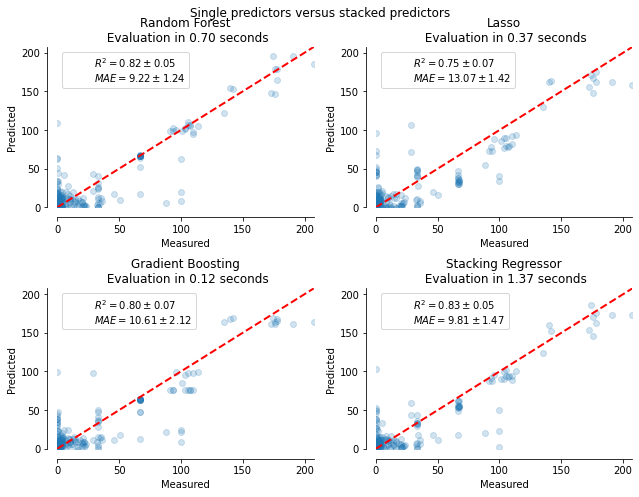

In [112]:
X = X_test
y = y_test
import time
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_validate, cross_val_predict


def plot_regression_results(ax, y_true, y_pred, title, scores, elapsed_time):
    """Scatter plot of the predicted vs true targets."""
    ax.plot([y_true.min(), y_true.max()],
            [y_true.min(), y_true.max()],
            '--r', linewidth=2)
    ax.scatter(y_true, y_pred, alpha=0.2)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    ax.spines['left'].set_position(('outward', 10))
    ax.spines['bottom'].set_position(('outward', 10))
    ax.set_xlim([y_true.min(), y_true.max()])
    ax.set_ylim([y_true.min(), y_true.max()])
    ax.set_xlabel('Measured')
    ax.set_ylabel('Predicted')
    extra = plt.Rectangle((0, 0), 0, 0, fc="w", fill=False,
                          edgecolor='none', linewidth=0)
    ax.legend([extra], [scores], loc='upper left')
    title = title + '\n Evaluation in {:.2f} seconds'.format(elapsed_time)
    ax.set_title(title)


fig, axs = plt.subplots(2, 2, figsize=(9, 7))
axs = np.ravel(axs)

for ax, (name, est) in zip(axs, estimators + [('Stacking Regressor',
                                               stacking_regressor)]):
    start_time = time.time()
    score = cross_validate(est, X, y,
                           scoring=['r2', 'neg_mean_absolute_error'],
                           n_jobs=-1, verbose=0)
    elapsed_time = time.time() - start_time

    y_pred = cross_val_predict(est, X, y, n_jobs=-1, verbose=0)

    plot_regression_results(
        ax, y, y_pred,
        name,
        (r'$R^2={:.2f} \pm {:.2f}$' + '\n' + r'$MAE={:.2f} \pm {:.2f}$')
        .format(np.mean(score['test_r2']),
                np.std(score['test_r2']),
                -np.mean(score['test_neg_mean_absolute_error']),
                np.std(score['test_neg_mean_absolute_error'])),
        elapsed_time)

plt.suptitle('Single predictors versus stacked predictors')
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

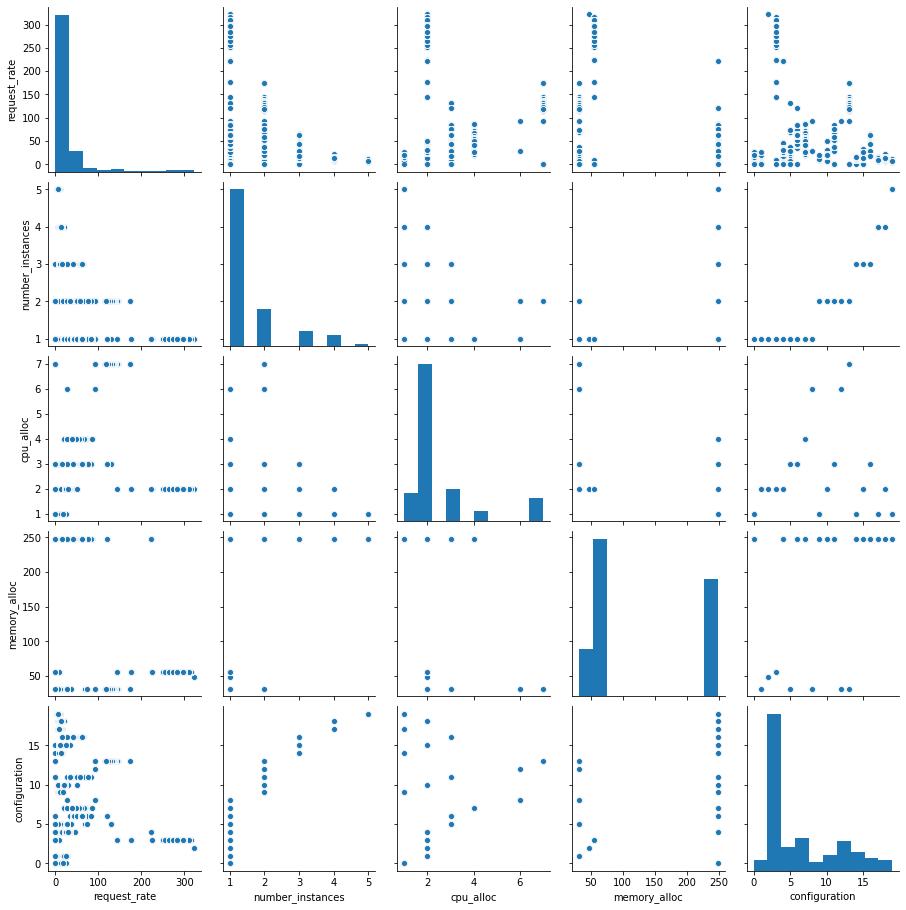

In [42]:
import seaborn as sns
sns.pairplot(data = df_imp_2.drop(columns=['performance', 'served_request','response_time', 'memory' , 'cpu_usage']), vars=df_imp_2.drop(columns=['performance', 'served_request','response_time', 'memory' , 'cpu_usage']).columns)
plt.show()

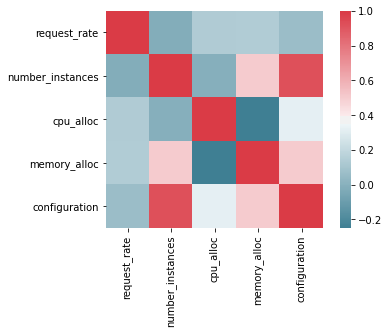

In [43]:
import seaborn as sns
corr = df_imp_2.drop(columns=['performance', 'served_request','response_time', 'memory' , 'cpu_usage']).corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True), square=True)

#### The same but with importance writen within in each cell 

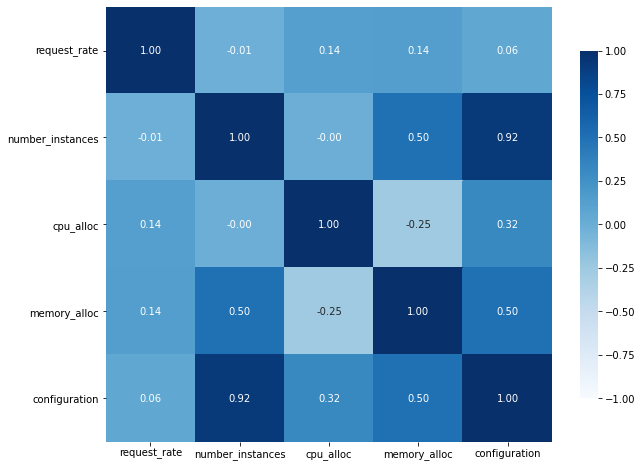

In [44]:
fig, ax = plt.subplots(figsize=(10, 8))
corr = df_imp_2.drop(columns=['performance', 'served_request','response_time', 'memory' , 'cpu_usage']).corr()
# plot heatmap
sns.heatmap(corr,  annot=True, fmt=".2f", cmap='Blues',
           vmin=-1, vmax=1, cbar_kws={"shrink": .8})
# yticks
plt.yticks(rotation=0)
plt.show()